In [1]:
from dask.distributed import Client

client = Client("tcp://127.0.0.1:50662")
client

<Client: 'tcp://127.0.0.1:50662' processes=8 threads=40, memory=169.33 GB>

In [3]:
import numpy as np
import xarray as xr
# from dask.diagnostics import ProgressBar
import os.path as op
import xrft
import gsw
from scipy.interpolate import PchipInterpolator, interp1d
from xgcm.grid import Grid as xgrid
from xmitgcm import open_mdsdataset
from MITgcmutils import jmd95
import matplotlib.colors as clr
import matplotlib.pyplot as plt
%matplotlib inline

In [4]:
from xlayers import finegrid, layers
from xlayers.core import layers_numpy

In [5]:
ddir = '/tank/chaocean/'
savedir = '/tank/topog/tuchida/TWA/'

In [6]:
grav = 9.81
nensembs = 23
Kh = 20.
K4 = 1e10
Kr = 1e-5
thetaMax = 1e20
ystart = 10
yend = 50
t_of_interest = 1

In [6]:
xchunk = 500

# for memb in range(24):
#     if memb == 0:
dsocn = open_mdsdataset(op.join(ddir,'qjamet/RUNS/ORAR/memb%02d/run2012/ocn/' % 23), 
                        grid_dir = op.join(ddir,'grid_chaO/gridMIT_update1/'),
                        prefix = ['diag_ocnTave','diag_ocnSurf'], delta_t = 2e2
                       ).isel(time=slice(None,3)).chunk({'XC':xchunk,'XG':xchunk})

dsaml = open_mdsdataset(op.join(ddir,'qjamet/RUNS/ORAR/memb%02d/run2012/cheapaml/' % 23), 
                        grid_dir = op.join(ddir,'grid_chaO/gridMIT_update1/'),
                        prefix = ['diag_cheapAML'], delta_t = 2e2
                       ).isel(time=slice(None,3)).chunk({'XC':xchunk,'XG':xchunk})
#     else:
#         ds = xr.concat([ds,open_mdsdataset(op.join(ddir,'qjamet/RUNS/ORAR/memb%02d/run2012/ocn/' % memb), 
#                                           grid_dir = op.join(ddir,'grid_chaO/gridMIT_update1/'),
#                                           prefix = ['diag_ocnTave','diag_ocnSurf'], delta_t = 2e2
#                                           ).isel(time=slice(None,3)).chunk({'XC':xchunk,'XG':xchunk})],
#                       dim='nmemb')
dsaml

/tank/users/tuchida/miniconda3/envs/ensemble/lib/python3.7/site-packages/xmitgcm/mds_store.py:217: FutureWarning: In xarray version 0.15 `auto_combine` will be deprecated. See
http://xarray.pydata.org/en/stable/combining.html#combining-multi
  ds = xr.auto_combine(datasets)
/tank/users/tuchida/miniconda3/envs/ensemble/lib/python3.7/site-packages/xmitgcm/mds_store.py:217: FutureWarning: The datasets supplied have global dimension coordinates. You may want
to use the new `combine_by_coords` function (or the
`combine='by_coords'` option to `open_mfdataset`) to order the datasets
before concatenation. Alternatively, to continue concatenating based
on the order the datasets are supplied in future, please use the new
`combine_nested` function (or the `combine='nested'` option to
open_mfdataset).The datasets supplied require both concatenation and merging. From
xarray version 0.15 this will operation will require either using the
new `combine_nested` function (or the `combine='nested'` option

<xarray.Dataset>
Dimensions:   (XC: 1000, XG: 1000, YC: 900, YG: 900, Z: 46, Zl: 46, Zp1: 47, Zu: 46, time: 3)
Coordinates:
    iter      (time) int64 dask.array<chunksize=(1,), meta=np.ndarray>
  * time      (time) float64 1.703e+09 1.704e+09 1.704e+09
  * XC        (XC) >f4 262.00003 262.0861 262.17215 ... 347.88644 347.9725
  * YC        (YC) >f4 -19.916634 -19.8333 -19.749968 ... 54.916702 55.000034
  * XG        (XG) >f4 261.957 262.04306 262.12912 ... 347.8434 347.92947
  * YG        (YG) >f4 -19.9583 -19.874968 -19.791634 ... 54.875034 54.95837
  * Z         (Z) >f4 -3.0467727 -9.454049 -16.363966 ... -5624.9517 -5875.141
  * Zp1       (Zp1) >f4 0.0 -6.0935454 -12.814552 ... -5749.9097 -6000.3726
  * Zu        (Zu) >f4 -6.0935454 -12.814552 -19.91338 ... -5749.9097 -6000.3726
  * Zl        (Zl) >f4 0.0 -6.0935454 -12.814552 ... -5499.9937 -5749.9097
    rA        (YC, XC) >f4 dask.array<chunksize=(900, 500), meta=np.ndarray>
    dxG       (YG, XC) >f4 dask.array<chunksize=(900, 

In [23]:
dt = dsocn.time.diff('time')[0]
dt

<xarray.DataArray 'time' ()>
array(432000.)
Coordinates:
    iter     int64 8519040
    time     float64 1.704e+09

In [8]:
dsdiag = open_mdsdataset(op.join(ddir,'qjamet/RUNS/ORAR/memb%02d/run2012_diagTSbgt/ocn/' % 23), 
                        grid_dir = op.join(ddir,'grid_chaO/gridMIT_update1/'),
                        prefix = ['diagTbgt2D','diagTbgt3D'], delta_t = 2e2
                        ).chunk({'XC':xchunk,'XG':xchunk})
dsdiag

/tank/users/tuchida/miniconda3/envs/ensemble/lib/python3.7/site-packages/xmitgcm/mds_store.py:217: FutureWarning: In xarray version 0.15 `auto_combine` will be deprecated. See
http://xarray.pydata.org/en/stable/combining.html#combining-multi
  ds = xr.auto_combine(datasets)
/tank/users/tuchida/miniconda3/envs/ensemble/lib/python3.7/site-packages/xmitgcm/mds_store.py:217: FutureWarning: The datasets supplied have global dimension coordinates. You may want
to use the new `combine_by_coords` function (or the
`combine='by_coords'` option to `open_mfdataset`) to order the datasets
before concatenation. Alternatively, to continue concatenating based
on the order the datasets are supplied in future, please use the new
`combine_nested` function (or the `combine='nested'` option to
open_mfdataset).The datasets supplied require both concatenation and merging. From
xarray version 0.15 this will operation will require either using the
new `combine_nested` function (or the `combine='nested'` option

<xarray.Dataset>
Dimensions:   (XC: 1000, XG: 1000, YC: 900, YG: 900, Z: 46, Zl: 46, Zp1: 47, Zu: 46, time: 2)
Coordinates:
    iter      (time) int64 dask.array<chunksize=(1,), meta=np.ndarray>
  * time      (time) float64 1.703e+09 1.704e+09
  * XC        (XC) >f4 262.00003 262.0861 262.17215 ... 347.88644 347.9725
  * YC        (YC) >f4 -19.916634 -19.8333 -19.749968 ... 54.916702 55.000034
  * XG        (XG) >f4 261.957 262.04306 262.12912 ... 347.8434 347.92947
  * YG        (YG) >f4 -19.9583 -19.874968 -19.791634 ... 54.875034 54.95837
  * Z         (Z) >f4 -3.0467727 -9.454049 -16.363966 ... -5624.9517 -5875.141
  * Zp1       (Zp1) >f4 0.0 -6.0935454 -12.814552 ... -5749.9097 -6000.3726
  * Zu        (Zu) >f4 -6.0935454 -12.814552 -19.91338 ... -5749.9097 -6000.3726
  * Zl        (Zl) >f4 0.0 -6.0935454 -12.814552 ... -5499.9937 -5749.9097
    rA        (YC, XC) >f4 dask.array<chunksize=(900, 500), meta=np.ndarray>
    dxG       (YG, XC) >f4 dask.array<chunksize=(900, 500), meta

In [37]:
# dt = np.diff(ds.time)[0]
# ds.coords['timep1'] = ('timep1',np.append(np.append(ds.time[0].data-.5*dt,.5*(ds.time[1:].data+ds.time[:-1].data)),
#                                          ds.time[-1].data+.5*dt))
# ds
dsocn

<xarray.Dataset>
Dimensions:  (XC: 1000, XG: 1000, YC: 900, YG: 900, Z: 46, Zl: 46, Zp1: 47, Zu: 46, time: 3)
Coordinates:
  * XC       (XC) >f4 262.00003 262.0861 262.17215 ... 347.88644 347.9725
  * YC       (YC) >f4 -19.916634 -19.8333 -19.749968 ... 54.916702 55.000034
  * XG       (XG) >f4 261.957 262.04306 262.12912 ... 347.8434 347.92947
  * YG       (YG) >f4 -19.9583 -19.874968 -19.791634 ... 54.875034 54.95837
  * Z        (Z) >f4 -3.0467727 -9.454049 -16.363966 ... -5624.9517 -5875.141
  * Zp1      (Zp1) >f4 0.0 -6.0935454 -12.814552 ... -5749.9097 -6000.3726
  * Zu       (Zu) >f4 -6.0935454 -12.814552 -19.91338 ... -5749.9097 -6000.3726
  * Zl       (Zl) >f4 0.0 -6.0935454 -12.814552 ... -5499.9937 -5749.9097
    rA       (YC, XC) >f4 dask.array<chunksize=(900, 500), meta=np.ndarray>
    dxG      (YG, XC) >f4 dask.array<chunksize=(900, 500), meta=np.ndarray>
    dyG      (YC, XG) >f4 dask.array<chunksize=(900, 500), meta=np.ndarray>
    Depth    (YC, XC) >f4 dask.array<chunk

In [10]:
gridz = xgrid(dsocn, periodic=['X'], 
             coords={'T':{'center':'time'},
                    'Z':{'center':'Z','outer':'Zp1','left':'Zl'},
                    'Y':{'center':'YC','left':'YG'},
                    'X':{'center':'XC','left':'XG'}})
gridz

<xgcm.Grid>
T Axis (not periodic):
  * center   time
Z Axis (not periodic):
  * center   Z --> left
  * outer    Zp1 --> center
  * left     Zl --> center
Y Axis (not periodic):
  * center   YC --> left
  * left     YG --> center
X Axis (periodic):
  * center   XC --> left
  * left     XG --> center

# Continuity in $z$ coordinates
$$\nabla \cdot {\bf v} = \frac{\delta_x\Delta y_g\Delta r_f h_w u + \delta_y\Delta x_g\Delta r_f h_s v + \delta_z A_c w}{A_c h_c \Delta r_f} \sim 0$$

In [9]:
div = (gridz.diff(ds.UVEL.where(ds.maskW!=0.)*ds.hFacW*ds.drF*ds.dyG,'X') 
       + gridz.diff(ds.VVEL.where(ds.maskS!=0.)*ds.hFacS*ds.drF*ds.dxG,'Y',boundary='fill')
       - gridz.diff(ds.WVEL*ds.rA,'Z',boundary='fill')
      ) * (ds.rA*ds.hFacC*ds.drF)**-1
div

<xarray.DataArray (time: 3, Z: 46, YC: 900, XC: 1000)>
dask.array<mul, shape=(3, 46, 900, 1000), dtype=float32, chunksize=(1, 45, 899, 499), chunktype=numpy.ndarray>
Coordinates:
  * time     (time) float64 1.703e+09 1.704e+09 1.704e+09
  * Z        (Z) >f4 -3.0467727 -9.454049 -16.363966 ... -5624.9517 -5875.141
  * YC       (YC) >f4 -19.916634 -19.8333 -19.749968 ... 54.916702 55.000034
  * XC       (XC) >f4 262.00003 262.0861 262.17215 ... 347.88644 347.9725
    rA       (YC, XC) >f4 83341540.0 83341540.0 ... 50843696.0 50843696.0
    Depth    (YC, XC) >f4 3440.756 3215.3306 2099.5483 ... 2916.6108 2823.8076
    maskInC  (YC, XC) bool False False False False ... False False False False
    drF      (Z) >f4 6.0935454 6.721007 7.098827 ... 249.91599 250.46292
    PHrefC   (Z) >f4 29.88884 92.74422 160.5305 ... 55180.777 57635.133
    hFacC    (Z, YC, XC) >f4 dask.array<chunksize=(46, 900, 500), meta=np.ndarray>
    maskC    (Z, YC, XC) bool dask.array<chunksize=(46, 900, 500), meta=np

In [21]:
div2D = (gridz.diff(ds.UVEL.where(ds.maskW!=0.)*ds.hFacW*ds.drF*ds.dyG,'X') 
         + gridz.diff(ds.VVEL.where(ds.maskS!=0.)*ds.hFacS*ds.drF*ds.dxG,'Y',boundary='fill')
        ) * (ds.rA*ds.hFacC*ds.drF)**-1

/tank/users/tuchida/miniconda3/envs/ensemble/lib/python3.7/site-packages/dask/core.py:119: RuntimeWarning: divide by zero encountered in reciprocal
  return func(*args2)


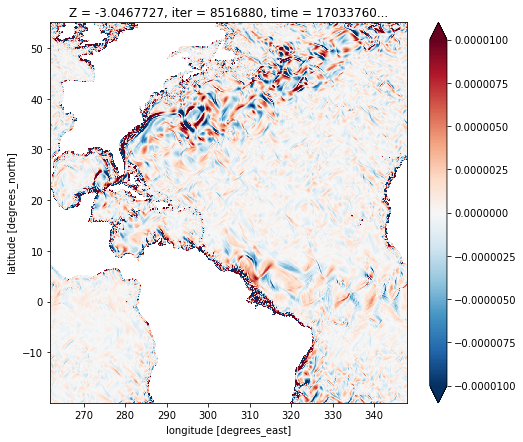

In [18]:
(gridz.diff(ds.UVEL.where(ds.maskW!=0.)*ds.hFacW*ds.drF*ds.dyG,'X')
 *(ds.rA*ds.hFacC*ds.drF)**-1)[0].plot(figsize=(8,7), vmax=1e-5)

/tank/users/tuchida/miniconda3/envs/ensemble/lib/python3.7/site-packages/dask/core.py:119: RuntimeWarning: divide by zero encountered in reciprocal
  return func(*args2)


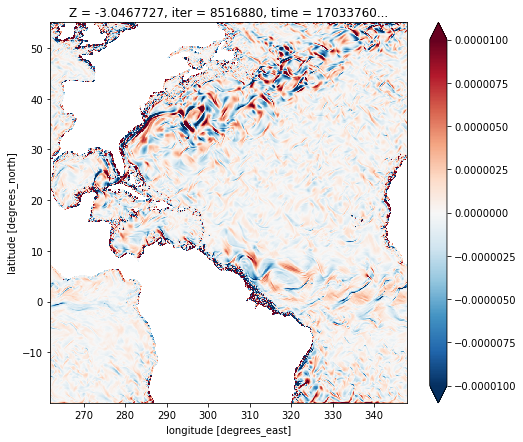

In [19]:
(gridz.diff(ds.VVEL.where(ds.maskS!=0.)*ds.hFacS*ds.drF*ds.dxG,'Y',boundary='fill')
 *(ds.rA*ds.hFacC*ds.drF)**-1)[0].plot(figsize=(8,7), vmax=1e-5)

/tank/users/tuchida/miniconda3/envs/ensemble/lib/python3.7/site-packages/dask/core.py:119: RuntimeWarning: divide by zero encountered in reciprocal
  return func(*args2)
/tank/users/tuchida/miniconda3/envs/ensemble/lib/python3.7/site-packages/dask/core.py:119: RuntimeWarning: invalid value encountered in multiply
  return func(*args2)


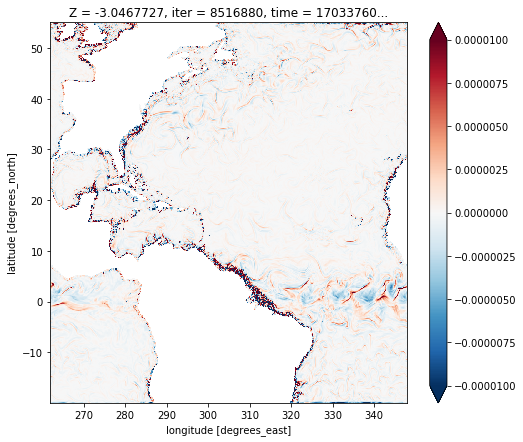

In [28]:
(-gridz.diff(ds.WVEL*ds.rA,'Z',boundary='fill')*(ds.rA*ds.hFacC*ds.drF)**-1)[0].plot(figsize=(8,7), vmax=1e-5)

/tank/users/tuchida/miniconda3/envs/ensemble/lib/python3.7/site-packages/dask/core.py:119: RuntimeWarning: divide by zero encountered in reciprocal
  return func(*args2)


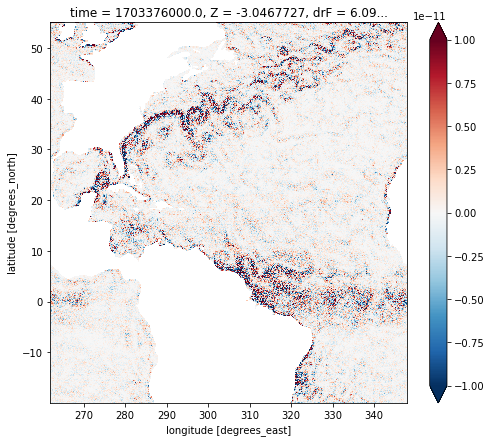

In [114]:
div[0,0].plot(figsize=(8,7), vmax=1e-11)

/tank/users/tuchida/miniconda3/envs/ensemble/lib/python3.7/site-packages/dask/core.py:119: RuntimeWarning: divide by zero encountered in reciprocal
  return func(*args2)
/tank/users/tuchida/miniconda3/envs/ensemble/lib/python3.7/site-packages/dask/core.py:119: RuntimeWarning: invalid value encountered in multiply
  return func(*args2)
/tank/users/tuchida/miniconda3/envs/ensemble/lib/python3.7/site-packages/dask/core.py:119: RuntimeWarning: divide by zero encountered in true_divide
  return func(*args2)
/tank/users/tuchida/miniconda3/envs/ensemble/lib/python3.7/site-packages/dask/core.py:119: RuntimeWarning: invalid value encountered in true_divide
  return func(*args2)


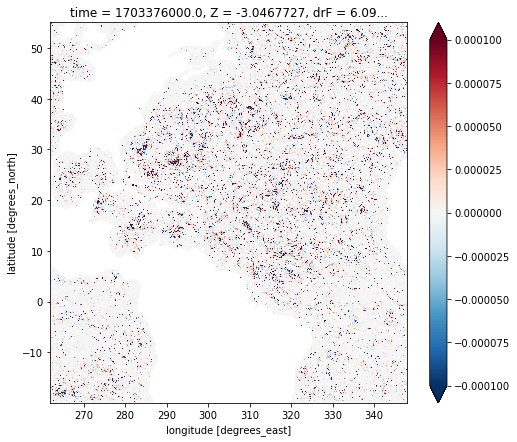

In [11]:
(div/-(gridz.diff(ds.WVEL*ds.rA,'Z',boundary='fill')*(ds.rA*ds.hFacC*ds.drF)**-1))[0,0].plot(figsize=(8,7), vmax=1e-4)

# Now in density coordinates

In [14]:
rho2 = xr.apply_ufunc(jmd95.densjmd95, dsocn.SALT, dsocn.THETA, 20e2, 
                     dask='parallelized', output_dtypes=[float]
                     )
rho2x = xr.apply_ufunc(jmd95.densjmd95, gridz.interp(dsocn.SALT,'X'), gridz.interp(dsocn.THETA,'X'), 20e2, 
                      dask='parallelized', output_dtypes=[float]
                      )
rho2y = xr.apply_ufunc(jmd95.densjmd95, gridz.interp(dsocn.SALT,'Y',boundary='fill'), 
                      gridz.interp(dsocn.THETA,'Y',boundary='fill'), 20e2, 
                      dask='parallelized', output_dtypes=[float]
                      )
rho2

<xarray.DataArray (time: 3, Z: 46, YC: 900, XC: 1000)>
dask.array<densjmd95, shape=(3, 46, 900, 1000), dtype=float64, chunksize=(1, 46, 900, 500), chunktype=numpy.ndarray>
Coordinates:
  * XC       (XC) >f4 262.00003 262.0861 262.17215 ... 347.88644 347.9725
  * YC       (YC) >f4 -19.916634 -19.8333 -19.749968 ... 54.916702 55.000034
  * Z        (Z) >f4 -3.0467727 -9.454049 -16.363966 ... -5624.9517 -5875.141
    rA       (YC, XC) >f4 83341540.0 83341540.0 ... 50843696.0 50843696.0
    Depth    (YC, XC) >f4 3440.756 3215.3306 2099.5483 ... 2916.6108 2823.8076
    drF      (Z) >f4 6.0935454 6.721007 7.098827 ... 249.91599 250.46292
    PHrefC   (Z) >f4 29.88884 92.74422 160.5305 ... 55180.777 57635.133
    hFacC    (Z, YC, XC) >f4 1.0 1.0 1.0 1.0 1.0 1.0 ... 0.0 0.0 0.0 0.0 0.0 0.0
    maskC    (Z, YC, XC) bool True True True True ... False False False False
    maskInC  (YC, XC) bool False False False False ... False False False False
    iter     (time) int64 8516880 8519040 8521200


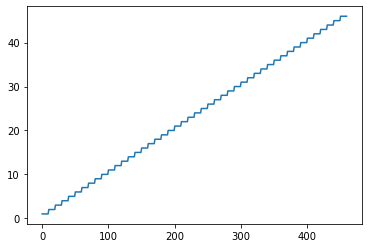

In [15]:
drf_finer, mapindex, mapfact, cellindex = finegrid.finegrid(np.squeeze(dsocn.drF.sel(Z=slice(None,None))),
                                                            np.squeeze(dsocn.drC.sel(Zp1=slice(None,None))),
                                                            10)
drc_finer, _, _, _ = finegrid.finegrid(np.squeeze(dsocn.drC.isel(Zp1=slice(None,-1))),
                                      np.squeeze(dsocn.drC.sel(Zp1=slice(None,None))),
                                      10)

plt.plot(cellindex)

In [16]:
Dsig = 9.7
nlayers = 43
# tmp = np.log(np.linspace(np.exp(1),np.exp(10),101))
# tmp2 = tmp[1:] - tmp[1]
# tmp2 *= tmp2[-1]**-1 * Dsig
# print(tmp2)
tmp = np.tanh(np.linspace(-2.,2.75,nlayers))
tmp += np.abs(tmp.min())
tmp *= tmp.max()**-1 * Dsig
# print(tmp)
siglayers = 27.5 + tmp
func = interp1d(range(1,nlayers+1), siglayers, fill_value='extrapolate')
sigp1layers = func(np.arange(.5,nlayers+1.5,1))

In [17]:
xA = dsocn.hFacW * dsocn.dyG * dsocn.drF
yA = dsocn.hFacS * dsocn.dxG * dsocn.drF
dxC_r = dsocn.dxC**-1
dyC_r = dsocn.dyC**-1
dxG_r = dsocn.dxG**-1
dyG_r = dsocn.dyG**-1
rA_r = dsocn.rA**-1
dV_r = dsocn.hFacC**-1*rA_r*dsocn.drF**-1
theta = dsocn.THETA.load()
psu = dsocn.SALT.load()

In [20]:
FdiffTx = -Kh * gridz.diff(theta[t_of_interest],'X') * xA * dxC_r
FdiffTy = -Kh * gridz.diff(theta[t_of_interest],'Y',boundary='fill') * yA * dyC_r
FdiffTr = (Kr * gridz.diff(theta[t_of_interest],'Z',boundary='fill') * dsocn.rA 
           * dsocn.drC.data[:-1][:,np.newaxis,np.newaxis]**-1)  # rhoFacF = 1. due to Boussinesq approx.

delh2T = (gridz.diff((gridz.diff(theta[t_of_interest],'X')*xA*dxC_r).where(dsocn.maskW!=0.),
                     'X')
          + gridz.diff((gridz.diff(theta[t_of_interest],'Y',boundary='fill'
                                  )*yA*dyC_r).where(dsocn.maskS!=0.), 
                       'Y', boundary='fill')
         ) * rA_r * (dsocn.drF*dsocn.hFacC)**-1
FdiffTx += K4 * gridz.diff(delh2T,'X') * xA * dxC_r
FdiffTy += K4 * gridz.diff(delh2T,'Y',boundary='fill') * yA * dyC_r
 
################
# Fdiffsx = -Kh * gridz.diff(psu[t_of_interest],'X') * xA * dxC_r
# Fdiffsy = -Kh * gridz.diff(psu[t_of_interest],'Y',boundary='fill') * yA * dyC_r
# Fdiffsr = (Kr * gridz.diff(psu[t_of_interest],'Z',boundary='fill') * ds.rA 
#            * ds.drC.data[:-1][:,np.newaxis,np.newaxis]**-1)  # rhoFacF = 1. due to Boussinesq approx.

# delh2s = (gridz.diff((gridz.diff(psu[t_of_interest],'X')*xA*dxC_r).where(ds.maskW!=0.),
#                     'X')
#          + gridz.diff((gridz.diff(psu[t_of_interest],'Y',boundary='fill')*yA*dyC_r).where(ds.maskS!=0.), 
#                      'Y', boundary='fill')
#          ) * rA_r * (ds.drF*ds.hFacC)**-1
# Fdiffsx += K4 * gridz.diff(delh2s,'X') * xA * dxC_r
# Fdiffsy += K4 * gridz.diff(delh2s,'Y',boundary='fill') * yA * dyC_r
 
################
GdiffT = -((gridz.diff(FdiffTx,'X') + gridz.diff(FdiffTy,'Y',boundary='fill')).where(dsocn.maskC!=0.)
           - gridz.diff(FdiffTr.where(dsocn.maskInC!=0.),'Z',boundary='fill')
          ) * (dsocn.hFacC*dsocn.drF)**-1 * rA_r
# Gdiffs = -((gridz.diff(Fdiffsx,'X') + gridz.diff(Fdiffsy,'Y',boundary='fill')).where(ds.maskC!=0.)
#            - gridz.diff(Fdiffsr.where(gridz.interp(ds.maskC,'Z',boundary='extend')!=0.),'Z',boundary='fill')
#           ) * (ds.hFacC*ds.drF)**-1 * rA_r

print(GdiffT)

<xarray.DataArray (Z: 46, YC: 900, XC: 1000)>
dask.array<mul, shape=(46, 900, 1000), dtype=float32, chunksize=(45, 897, 497), chunktype=numpy.ndarray>
Coordinates:
  * Z        (Z) >f4 -3.0467727 -9.454049 -16.363966 ... -5624.9517 -5875.141
  * YC       (YC) >f4 -19.916634 -19.8333 -19.749968 ... 54.916702 55.000034
  * XC       (XC) >f4 262.00003 262.0861 262.17215 ... 347.88644 347.9725
    rA       (YC, XC) >f4 83341540.0 83341540.0 ... 50843696.0 50843696.0
    Depth    (YC, XC) >f4 3440.756 3215.3306 2099.5483 ... 2916.6108 2823.8076
    drF      (Z) >f4 6.0935454 6.721007 7.098827 ... 249.91599 250.46292
    PHrefC   (Z) >f4 29.88884 92.74422 160.5305 ... 55180.777 57635.133
    hFacC    (Z, YC, XC) >f4 1.0 1.0 1.0 1.0 1.0 1.0 ... 0.0 0.0 0.0 0.0 0.0 0.0
    maskC    (Z, YC, XC) bool True True True True ... False False False False
    maskInC  (YC, XC) bool False False False False ... False False False False


In [17]:
DiffE = - (-gridz.diff(dsdiag.DFrE_TH,'Z',boundary='fill') * dV_r
           + gridz.diff(dsdiag.DFxE_TH,'X') * dV_r
           + gridz.diff(dsdiag.DFyE_TH,'Y',boundary='fill') * dV_r
          ).where(dsdiag.maskC!=0.)
DiffI = (gridz.diff(dsdiag.DFrI_TH,'Z',boundary='fill') * dV_r).where(dsdiag.maskC!=0.)
DiffE

<xarray.DataArray (time: 2, Z: 46, YC: 900, XC: 1000)>
dask.array<neg, shape=(2, 46, 900, 1000), dtype=float32, chunksize=(1, 45, 899, 499), chunktype=numpy.ndarray>
Coordinates:
  * time     (time) float64 1.703e+09 1.704e+09
  * Z        (Z) >f4 -3.0467727 -9.454049 -16.363966 ... -5624.9517 -5875.141
  * YC       (YC) >f4 -19.916634 -19.8333 -19.749968 ... 54.916702 55.000034
  * XC       (XC) >f4 262.00003 262.0861 262.17215 ... 347.88644 347.9725
    rA       (YC, XC) >f4 83341540.0 83341540.0 ... 50843696.0 50843696.0
    Depth    (YC, XC) >f4 3440.756 3215.3306 2099.5483 ... 2916.6108 2823.8076
    drF      (Z) >f4 6.0935454 6.721007 7.098827 ... 249.91599 250.46292
    PHrefC   (Z) >f4 29.88884 92.74422 160.5305 ... 55180.777 57635.133
    hFacC    (Z, YC, XC) >f4 1.0 1.0 1.0 1.0 1.0 1.0 ... 0.0 0.0 0.0 0.0 0.0 0.0
    maskC    (Z, YC, XC) bool True True True True ... False False False False
    maskInC  (YC, XC) bool False False False False ... False False False False

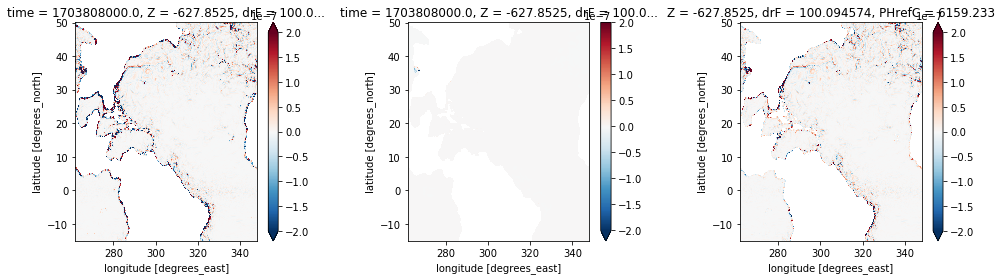

In [40]:
fig, (ax1,ax2,ax3) = plt.subplots(nrows=1, ncols=3, figsize=(14,4))
fig.set_tight_layout(True)
DiffE[t_of_interest,20].sel(YC=slice(-15,50+12**-1)).plot(ax=ax1, vmax=2e-7)
DiffI[t_of_interest,20].sel(YC=slice(-15,50+12**-1)).plot(ax=ax2, vmax=2e-7)
GdiffT[20].sel(YC=slice(-15,50+12**-1)).plot(ax=ax3, vmax=2e-7)

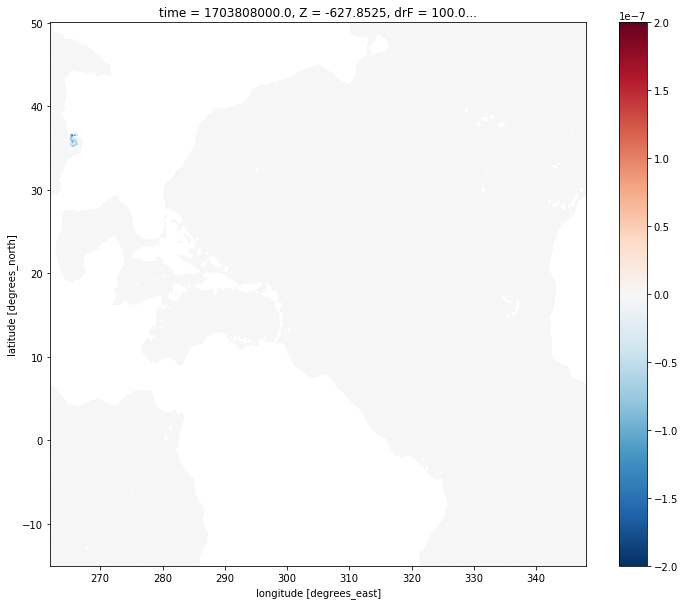

In [41]:
((DiffE+DiffI)[t_of_interest,20]-GdiffT[20]).sel(YC=slice(-15,50+12**-1)).plot(figsize=(12,10), vmax=2e-7)

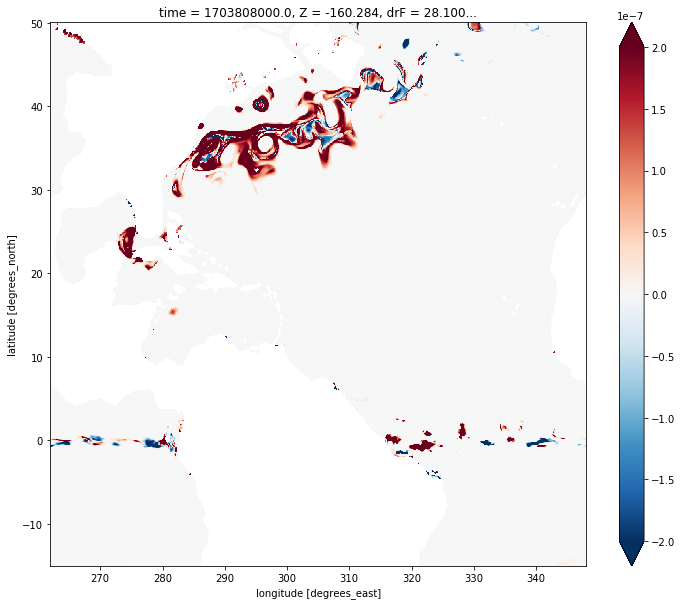

In [38]:
(DiffE+DiffI-GdiffT)[t_of_interest,12].sel(YC=slice(-15,50+12**-1)).plot(figsize=(12,10), vmax=2e-7)

In [25]:
Rs = gridz.diff(theta[t_of_interest],'X').where(dsocn.maskW!=0)
uCFL = np.abs(dsocn.UVEL[t_of_interest] * dt*dxC_r).where(dsocn.maskW!=0)
d0 = (2.-uCFL) * (1.-uCFL)/6
d1 = (1.-uCFL**2)/6
uTrans = dsocn.UVEL[t_of_interest].where(dsocn.maskW!=0) * xA

thetaP = Rs**-1 * np.roll(Rs,1,axis=-1)
thetaM = Rs**-1 * np.roll(Rs,-1,axis=-1)
# thetaP = xr.DataArray(thetaP.data, dims=Rs.dims, 
#                       coords={'Z':Rs.Z.data,'YC':Rs.YC.data,'XG':range(len(Rs.XG))}).load()
# thetaM = xr.DataArray(thetaM.data, dims=Rs.dims, 
#                       coords={'Z':Rs.Z.data,'YC':Rs.YC.data,'XG':range(len(Rs.XG))}).load()
# tempo = xr.DataArray(Rs.data, dims=Rs.dims, 
#                      coords={'Z':Rs.Z.data,'YC':Rs.YC.data,'XG':range(len(Rs.XG))})
# for k in range(len(Rs.Z)):
#     for j in range(len(Rs.YC)):
# #         if ~np.isnan(Rs[k,j]):
#         mask = np.abs(tempo[k,j])*thetaMax <= np.abs(np.roll(tempo[k,j],-1,axis=-1))
#         if len(mask.data) > 0:
#             thetaP[k,j].loc[mask] = thetaMax * np.sign(tempo[k,j]*np.roll(tempo[k,j].data,-1,axis=-1)).loc[mask]
#         mask = np.abs(tempo[k,j])*thetaMax <= np.abs(np.roll(tempo[k,j],1,axis=-1))
#         if len(mask.data) > 0:
#             thetaM[k,j].loc[mask] = thetaMax * np.sign(tempo[k,j]*np.roll(tempo[k,j].data,1,axis=-1)).loc[mask]
        
# thetaP.assign_coords({'XG':Rs.XG.data})
# thetaM.assign_coords({'XG':Rs.XG.data})

            
psiP = d0 + d1*thetaP
psiP = np.maximum(0.,np.minimum(np.minimum(1.,psiP),
                               thetaP*(1.-uCFL)/(uCFL+1e-20)
                               )
                 )
psiM = d0 + d1*thetaM
psiM = np.maximum(0.,np.minimum(np.minimum(1.,psiM),
                               thetaM*(1.-uCFL)/(uCFL+1e-20)
                               )
                 )

uT = (.5*(uTrans + np.abs(uTrans)) * (np.roll(theta[t_of_interest],1,axis=-1) + psiP*Rs)
      + .5*(uTrans - np.abs(uTrans)) * (theta[t_of_interest].data - psiM*Rs)
     )
onethird = theta[t_of_interest] - ((gridz.diff(uT,'X') 
                                    - theta[t_of_interest] * gridz.diff(uTrans,'X')
                                   )*dV_r*dt).where(dsocn.maskC!=0.)
onethird

<xarray.DataArray (Z: 46, YC: 900, XC: 1000)>
dask.array<subtract, shape=(46, 900, 1000), dtype=float64, chunksize=(46, 900, 499), chunktype=numpy.ndarray>
Coordinates:
  * XC       (XC) >f4 262.00003 262.0861 262.17215 ... 347.88644 347.9725
  * YC       (YC) >f4 -19.916634 -19.8333 -19.749968 ... 54.916702 55.000034
  * Z        (Z) >f4 -3.0467727 -9.454049 -16.363966 ... -5624.9517 -5875.141
    rA       (YC, XC) >f4 83341540.0 83341540.0 ... 50843696.0 50843696.0
    Depth    (YC, XC) >f4 3440.756 3215.3306 2099.5483 ... 2916.6108 2823.8076
    drF      (Z) >f4 6.0935454 6.721007 7.098827 ... 249.91599 250.46292
    PHrefC   (Z) >f4 29.88884 92.74422 160.5305 ... 55180.777 57635.133
    hFacC    (Z, YC, XC) >f4 1.0 1.0 1.0 1.0 1.0 1.0 ... 0.0 0.0 0.0 0.0 0.0 0.0
    maskC    (Z, YC, XC) bool True True True True ... False False False False
    maskInC  (YC, XC) bool False False False False ... False False False False
    iter     int64 8519040
    time     float64 1.704e+09

In [28]:
Rs = gridz.diff(onethird,'Y',boundary='fill').where(dsocn.maskS!=0)
vCFL = np.abs(dsocn.VVEL[t_of_interest] * dt*dyC_r).where(dsocn.maskS!=0)
d0 = (2.-vCFL) * (1.-vCFL)/6
d1 = (1.-vCFL**2)/6
vTrans = dsocn.VVEL[t_of_interest].where(dsocn.maskS!=0) * yA

thetaP = Rs**-1 * Rs.shift(YG=1)
thetaM = Rs**-1 * Rs.shift(YG=-1)

            
psiP = d0 + d1*thetaP
psiP = np.maximum(0.,np.minimum(np.minimum(1.,psiP),
                               thetaP*(1.-vCFL)/(vCFL+1e-20)
                               )
                 )
psiM = d0 + d1*thetaM
psiM = np.maximum(0.,np.minimum(np.minimum(1.,psiM),
                               thetaM*(1.-vCFL)/(vCFL+1e-20)
                               )
                 )

vT = (.5*(vTrans + np.abs(vTrans)) * (onethird.shift(YC=1).data + psiP*Rs)
      + .5*(vTrans - np.abs(vTrans)) * (onethird.data - psiM*Rs)
     )
twothird = onethird - ((gridz.diff(vT,'Y',boundary='fill') 
                        - theta[t_of_interest] * gridz.diff(vTrans,'Y',boundary='fill')
                       )*dV_r*dt).where(dsocn.maskC!=0.)

In [29]:
Rj = -gridz.diff(twothird,'Z',boundary='fill').where(dsocn.maskInC!=0)
Rjp = Rj.shift(Zl=-1).load()
Rjp.isel(Zl=-1)[:] = 0.
Rjm = Rj.shift(Zl=1).load()
Rjm.isel(Zl=0)[:] = 0.
wCFL = np.abs(dsocn.WVEL[t_of_interest] * dt*dsocn.drC.data[:-1,np.newaxis,np.newaxis]**-1).where(dsocn.maskInC!=0)
d0 = (2.-wCFL) * (1.-wCFL)/6
d1 = (1.-wCFL**2)/6
wTrans = dsocn.WVEL[t_of_interest].where(dsocn.maskInC!=0) * dsocn.rA

thetaP = Rj**-1 * Rjm
thetaM = Rj**-1 * Rjp

            
psiP = d0 + d1*thetaP
psiP = np.maximum(0.,np.minimum(np.minimum(1.,psiP),
                               thetaP*(1.-wCFL)/(wCFL+1e-20)
                               )
                 )
psiM = d0 + d1*thetaM
psiM = np.maximum(0.,np.minimum(np.minimum(1.,psiM),
                               thetaM*(1.-wCFL)/(wCFL+1e-20)
                               )
                 )

theta_rolled = twothird.shift(Z=1).load()
theta_rolled.isel(Z=0)[:] = twothird.isel(Z=0)
wT = (.5*(wTrans + np.abs(wTrans)) * (theta_rolled.data + psiP*Rj)
      + .5*(wTrans - np.abs(wTrans)) * (twothird.data - psiM*Rj)
     )
one = twothird + ((gridz.diff(wT,'Z',boundary='fill')  # - - = +
                   - theta[t_of_interest] * gridz.diff(wTrans,'Z',boundary='fill')
                  )*dV_r*dt).where(dsocn.maskC!=0.)

In [30]:
Adv = - (-gridz.diff(dsdiag.ADVr_TH,'Z',boundary='fill') * dV_r
         + gridz.diff(dsdiag.ADVx_TH,'X') * dV_r
         + gridz.diff(dsdiag.ADVy_TH,'Y',boundary='fill') * dV_r
        ).where(dsdiag.maskC!=0.)

GadvT = (one - theta[t_of_interest]) * dt**-1
GadvT

<xarray.DataArray (Z: 46, YC: 900, XC: 1000)>
dask.array<mul, shape=(46, 900, 1000), dtype=float64, chunksize=(44, 898, 499), chunktype=numpy.ndarray>
Coordinates:
  * XC       (XC) >f4 262.00003 262.0861 262.17215 ... 347.88644 347.9725
  * YC       (YC) >f4 -19.916634 -19.8333 -19.749968 ... 54.916702 55.000034
  * Z        (Z) >f4 -3.0467727 -9.454049 -16.363966 ... -5624.9517 -5875.141
    rA       (YC, XC) >f4 83341540.0 83341540.0 ... 50843696.0 50843696.0
    Depth    (YC, XC) >f4 3440.756 3215.3306 2099.5483 ... 2916.6108 2823.8076
    drF      (Z) >f4 6.0935454 6.721007 7.098827 ... 249.91599 250.46292
    PHrefC   (Z) >f4 29.88884 92.74422 160.5305 ... 55180.777 57635.133
    hFacC    (Z, YC, XC) >f4 1.0 1.0 1.0 1.0 1.0 1.0 ... 0.0 0.0 0.0 0.0 0.0 0.0
    maskC    (Z, YC, XC) bool True True True True ... False False False False
    maskInC  (YC, XC) bool False False False False ... False False False False
    iter     int64 8519040
    time     float64 1.704e+09

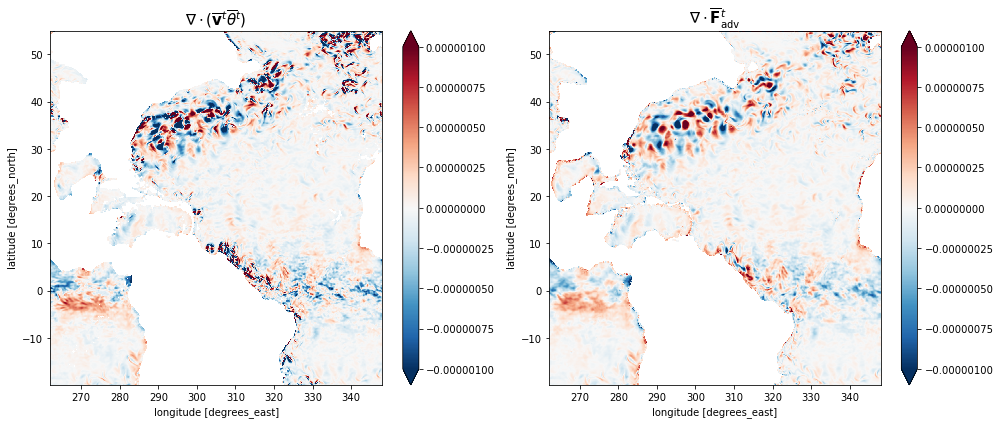

In [56]:
fig, (ax1,ax2) = plt.subplots(figsize=(14,6), nrows=1, ncols=2)
fig.set_tight_layout(True)
GadvT[22].plot(ax=ax1, vmax=1e-6, rasterized=True)
Adv[t_of_interest,22].plot(ax=ax2, vmax=1e-6, rasterized=True)
ax1.set_title(r"$\nabla\cdot(\overline{\mathbf{v}}^t\overline{\theta}^t)$", fontsize=15)
ax2.set_title(r"$\nabla\cdot\overline{\mathbf{F}}^t_{\tt adv}$", fontsize=15)
plt.savefig(op.join(savedir,'Figures/Advection_memb23_1-8-2012.pdf'))

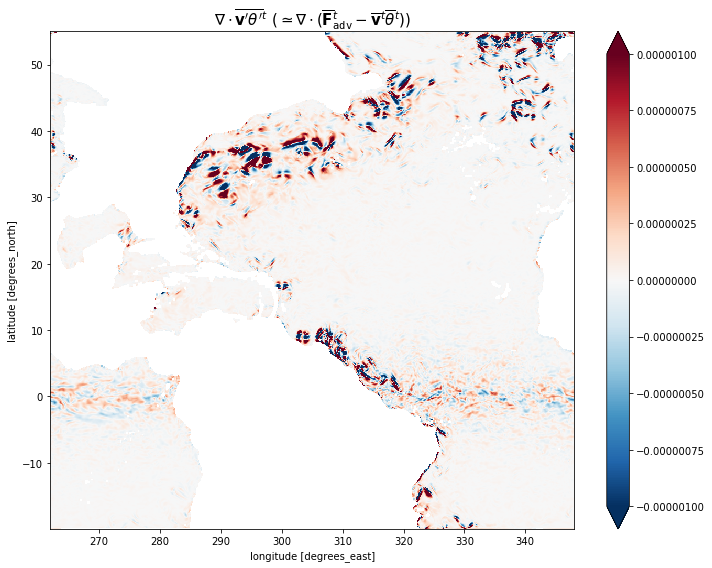

In [31]:
fig, ax = plt.subplots(figsize=(10,8))
fig.set_tight_layout(True)
(Adv-GadvT)[t_of_interest,22].plot(vmax=1e-6, rasterized=True)  # sum of Reynolds flux terms and numerical error
ax.set_title(r"$\nabla\cdot\overline{\mathbf{v}'\theta'}^t\ (\simeq\nabla\cdot(\overline{\mathbf{F}}^t_{\tt adv} - \overline{\mathbf{v}}^t\overline{\theta}^t))$", fontsize=15)
plt.savefig(op.join(savedir,'Figures/Reynolds-Advection_memb23_1-8-2012.pdf'))

In [330]:
dTdt = gridz.interp(gridz.diff(theta.where(ds.maskC!=0)*ds.rA*ds.drF*ds.hFacC,'T',boundary='fill') 
                    * dt**-1 * dV_r,
                   'T', boundary='fill')
dTdt

<xarray.DataArray 'mul-d4117cf345eec7b1592bf88614442ba6' (time: 3, Z: 46, YC: 900, XC: 1000)>
dask.array<mul, shape=(3, 46, 900, 1000), dtype=float32, chunksize=(1, 46, 900, 500), chunktype=numpy.ndarray>
Coordinates:
  * time     (time) float64 1.703e+09 1.704e+09 1.704e+09
  * Z        (Z) >f4 -3.0467727 -9.454049 -16.363966 ... -5624.9517 -5875.141
  * YC       (YC) >f4 -19.916634 -19.8333 -19.749968 ... 54.916702 55.000034
  * XC       (XC) >f4 262.00003 262.0861 262.17215 ... 347.88644 347.9725

[########################                ] | 61% Completed |  0.3s

/tank/users/tuchida/miniconda3/envs/ensemble/lib/python3.7/site-packages/dask/core.py:119: RuntimeWarning: divide by zero encountered in reciprocal
  return func(*args2)


[########################################] | 100% Completed |  1.8s


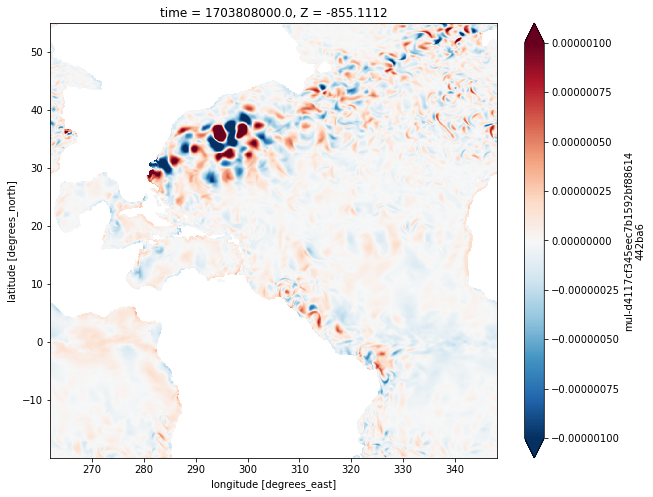

In [364]:
with ProgressBar():
    dTdt[1,22].plot(figsize=(10,8), vmax=1e-6)

In [20]:
with ProgressBar():
    vdz = xr.apply_ufunc(layers_numpy, 
                             ds.VVEL[t_of_interest].where(ds.maskS!=0.).sel(YG=slice(ystart-12**-1,
                                                                           yend+2*12**-1)).chunk({'XC':xchunk}),
                             (rho2y[t_of_interest]-1e3).where(ds.maskS!=0.).sel(YG=slice(ystart-12**-1,
                                                                               yend+2*12**-1)).chunk({'YG':-1,'XC':xchunk}),
                             kwargs={'thetalayers':siglayers,'mapfact':mapfact,
                                     'mapindex':mapindex,'cellindex':cellindex,
                                     'drf_finer':drf_finer},
                             dask='parallelized', 
                             input_core_dims=[['Z'],['Z']], 
                             output_core_dims=[['sig']],
    #                            output_core_dims=(['sig2lev']),
    #                          exclude_dims=set(['Z']),
                             output_dtypes=[float,], output_sizes={'sig':siglayers.size}
                             ).compute()

    udz = xr.apply_ufunc(layers_numpy, 
                             ds.UVEL[t_of_interest].where(ds.maskW!=0.).sel(YC=slice(ystart-12**-1,
                                                                           yend+2*12**-1)).chunk({'XG':xchunk}),
                             (rho2x[t_of_interest]-1e3).where(ds.maskW!=0.).sel(YC=slice(ystart-12**-1,
                                                                               yend+2*12**-1)).chunk({'XG':xchunk}),
                             kwargs={'thetalayers':siglayers,'mapfact':mapfact,
                                     'mapindex':mapindex,'cellindex':cellindex,
                                     'drf_finer':drf_finer},
                             dask='parallelized', 
                             input_core_dims=[['Z'],['Z']], 
                             output_core_dims=[['sig']],
    #                            output_core_dims=(['sig2lev']),
    #                          exclude_dims=set(['Z']),
                             output_dtypes=[float,], output_sizes={'sig':siglayers.size}
                             ).compute()

    Tdz = xr.apply_ufunc(layers_numpy, 
                            theta[t_of_interest].where(ds.maskC!=0.).sel(YC=slice(ystart-12**-1,
                                                                        yend+2*12**-1)).chunk({'XC':xchunk}),
                            (rho2[t_of_interest]-1e3).where(ds.maskC!=0.).sel(YC=slice(ystart-12**-1,
                                                                             yend+2*12**-1)).chunk({'XC':xchunk}),
                            kwargs={'thetalayers':siglayers,'mapfact':mapfact,
                                   'mapindex':mapindex,'cellindex':cellindex,
                                   'drf_finer':drf_finer},
                            dask='parallelized', 
                            input_core_dims=[['Z'],['Z']], 
                            output_core_dims=[['sig']],
    #                            output_core_dims=(['sig2lev']),
    #                            exclude_dims=set(['Z']),
                            output_dtypes=[float,], output_sizes={'sig':siglayers.size}
                            ).compute()

    sdz = xr.apply_ufunc(layers_numpy, 
                            psu[t_of_interest].where(ds.maskC!=0.).sel(YC=slice(ystart-12**-1,
                                                                      yend+2*12**-1)).chunk({'XC':xchunk}),
                            (rho2[t_of_interest]-1e3).where(ds.maskC!=0.).sel(YC=slice(ystart-12**-1,
                                                                             yend+2*12**-1)).chunk({'XC':xchunk}),
                            kwargs={'thetalayers':siglayers,'mapfact':mapfact,
                                    'mapindex':mapindex,'cellindex':cellindex,
                                    'drf_finer':drf_finer},
                            dask='parallelized', 
                            input_core_dims=[['Z'],['Z']], 
                            output_core_dims=[['sig']],
    #                            output_core_dims=(['sig2lev']),
    #                            exclude_dims=set(['Z']),
                            output_dtypes=[float,], output_sizes={'sig':siglayers.size}
                            ).compute()

    GTdz = xr.apply_ufunc(layers_numpy, 
                             GdiffT.where(ds.maskC!=0.).sel(YC=slice(ystart-12**-1,
                                                                          yend+2*12**-1)).chunk({'Z':-1,'YC':-1,'XC':xchunk}),
                             (rho2[t_of_interest]-1e3).where(ds.maskC!=0.).sel(YC=slice(ystart-12**-1,
                                                                              yend+2*12**-1)).chunk({'XC':xchunk}),
                             kwargs={'thetalayers':siglayers,'mapfact':mapfact,
                                    'mapindex':mapindex,'cellindex':cellindex,
                                    'drf_finer':drf_finer},
                             dask='parallelized', 
                             input_core_dims=[['Z'],['Z']], 
                             output_core_dims=[['sig']],
    #                            output_core_dims=(['sig2lev']),
    #                            exclude_dims=set(['Z']),
                             output_dtypes=[float,], output_sizes={'sig':siglayers.size}
                             ).compute()

    Gsdz = xr.apply_ufunc(layers_numpy, 
                             Gdiffs.where(ds.maskC!=0.).sel(YC=slice(ystart-12**-1,
                                                                          yend+2*12**-1)).chunk({'Z':-1,'YC':-1,'XC':xchunk}),
                             (rho2[t_of_interest]-1e3).where(ds.maskC!=0.).sel(YC=slice(ystart-12**-1,
                                                                              yend+2*12**-1)).chunk({'XC':xchunk}),
                             kwargs={'thetalayers':siglayers,'mapfact':mapfact,
                                    'mapindex':mapindex,'cellindex':cellindex,
                                    'drf_finer':drf_finer},
                             dask='parallelized', 
                             input_core_dims=[['Z'],['Z']], 
                             output_core_dims=[['sig']],
    #                            output_core_dims=(['sig2lev']),
    #                            exclude_dims=set(['Z']),
                             output_dtypes=[float,], output_sizes={'sig':siglayers.size}
                             ).compute()

#         tmpdzetaF = xr.apply_ufunc(layers_numpy, 
#                                    xr.ones_like(rho2[i]).where(ds.maskC!=0.).sel(YC=slice(-15,50+12**-1)).chunk({'XC':xchunk}),
#                                    (rho2[i]-1e3).where(ds.maskC!=0.).sel(YC=slice(-15,50+12**-1)).chunk({'XC':xchunk}),
#                                    kwargs={'thetalayers':siglayers,'mapfact':mapfact,
#                                            'mapindex':mapindex,'cellindex':cellindex,
#                                            'drf_finer':drf_finer},
#                                    dask='parallelized', 
#                                    input_core_dims=[['Z'],['Z']], 
#                                    output_core_dims=[['sig']],
#         #                            output_core_dims=(['sig2lev']),
#         #                            exclude_dims=set(['Z']),
#                                    output_dtypes=[float,], output_sizes={'sig':siglayers.size}
#                                   ).compute()
        
#     if i == 0:
#         udz = tmpu
#         vdz = tmpv
#         Tdz = tmpT
#         sdz = tmps
#         GTdz = tmpGT
#         Gsdz = tmpGs
# #         dzetaF = tmpdzetaF
#     else:
#         udz = xr.concat([udz, tmpu], dim='nmemb')
#         vdz = xr.concat([vdz, tmpv], dim='nmemb')
#         Tdz = xr.concat([Tdz, tmpT], dim='nmemb')
#         sdz = xr.concat([sdz, tmps], dim='nmemb')
#         GTdz = xr.concat([GTdz, tmpGT], dim='nmemb')
#         Gsdz = xr.concat([Gsdz, tmpGs], dim='nmemb')
# #         dzetaF = xr.concat([dzetaF, tmpdzetaF], dim='time')
    
# del tmpu, tmpv, tmpT, tmps, tmpGT, tmpGs

    
vdz = vdz.assign_coords({'sig':siglayers})
udz = udz.assign_coords({'sig':siglayers})
Tdz = Tdz.assign_coords({'sig':siglayers})
sdz = sdz.assign_coords({'sig':siglayers})
GTdz = GTdz.assign_coords({'sig':siglayers})
Gsdz = Gsdz.assign_coords({'sig':siglayers})
# dzetaF = dzetaF.assign_coords({'sig':siglayers})
vdz

[########################################] | 100% Completed |  0.1s
[########################################] | 100% Completed |  0.1s
[########################################] | 100% Completed |  0.1s
[########################################] | 100% Completed |  0.1s
[########################################] | 100% Completed |  0.1s
[########################################] | 100% Completed |  0.1s
[########################################] | 100% Completed |  0.1s
[########################################] | 100% Completed |  0.1s
[########################################] | 100% Completed |  0.1s
[########################################] | 100% Completed |  0.1s
[########################################] | 100% Completed |  0.1s
[########################################] | 100% Completed |  0.2s
[########################################] | 100% Completed |  0.1s
[########################################] | 100% Completed |  0.2s
[########################################] | 100

/tank/users/tuchida/miniconda3/envs/ensemble/lib/python3.7/site-packages/dask/core.py:119: RuntimeWarning: divide by zero encountered in reciprocal
  return func(*args2)


[####################################### ] | 99% Completed |  5.8sWarning: theta_in may not be monotonically ascending/descending
[####################################### ] | 99% Completed |  5.9sWarning: theta_in may not be monotonically ascending/descending
[########################################] | 100% Completed | 15.8s
[########################################] | 100% Completed |  0.1s
[########################################] | 100% Completed |  0.1s
[########################################] | 100% Completed |  0.1s
[########################################] | 100% Completed |  0.1s
[########################################] | 100% Completed |  0.2s
[########################################] | 100% Completed |  0.2s
[########################################] | 100% Completed |  0.1s
[########################################] | 100% Completed |  0.1s
[########################################] | 100% Completed |  0.1s
[########################################] | 100% Completed 

/tank/users/tuchida/miniconda3/envs/ensemble/lib/python3.7/site-packages/dask/core.py:119: RuntimeWarning: divide by zero encountered in reciprocal
  return func(*args2)


[####################################### ] | 99% Completed |  6.0sWarning: theta_in may not be monotonically ascending/descending
[####################################### ] | 99% Completed |  6.1sWarning: theta_in may not be monotonically ascending/descending
[########################################] | 100% Completed | 14.4s


<xarray.DataArray (YG: 483, XC: 1000, sig: 43)>
array([[[nan,  0.,  0., ...,  0.,  0.,  0.],
        [nan,  0.,  0., ...,  0.,  0.,  0.],
        [nan,  0.,  0., ...,  0.,  0.,  0.],
        ...,
        [nan,  0.,  0., ...,  0.,  0.,  0.],
        [nan,  0.,  0., ...,  0.,  0.,  0.],
        [nan,  0.,  0., ...,  0.,  0.,  0.]],

       [[nan,  0.,  0., ...,  0.,  0.,  0.],
        [nan,  0.,  0., ...,  0.,  0.,  0.],
        [nan,  0.,  0., ...,  0.,  0.,  0.],
        ...,
        [nan,  0.,  0., ...,  0.,  0.,  0.],
        [nan,  0.,  0., ...,  0.,  0.,  0.],
        [nan,  0.,  0., ...,  0.,  0.,  0.]],

       [[nan,  0.,  0., ...,  0.,  0.,  0.],
        [nan,  0.,  0., ...,  0.,  0.,  0.],
        [nan,  0.,  0., ...,  0.,  0.,  0.],
        ...,
        [nan,  0.,  0., ...,  0.,  0.,  0.],
        [nan,  0.,  0., ...,  0.,  0.,  0.],
        [nan,  0.,  0., ...,  0.,  0.,  0.]],

       ...,

       [[nan,  0.,  0., ...,  0.,  0.,  0.],
        [nan,  0.,  0., ...,  0.,  0., 

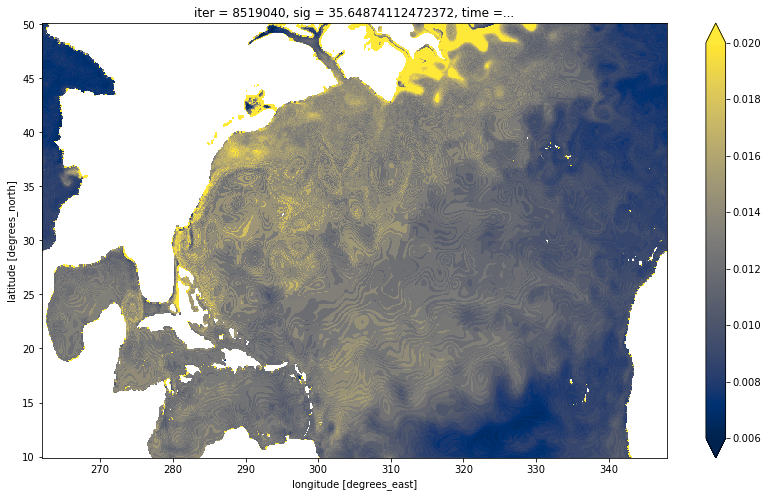

In [153]:
(dzetaF[t_of_interest]**-1)[:,:,25].where(ds.maskInC!=0.).plot(figsize=(14,8), vmin=6e-3, vmax=2e-2, cmap='cividis')

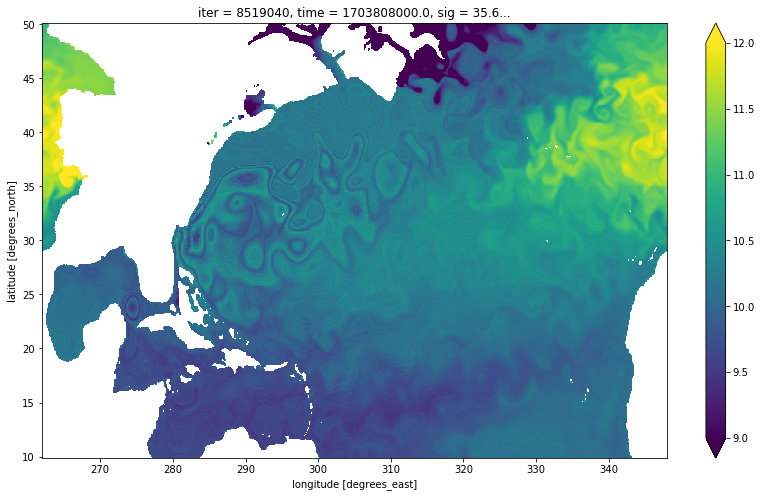

In [126]:
((Tdz*dzetaF[t_of_interest]**-1)[:,:,25]).where(ds.maskInC!=0.).plot(figsize=(14,8), vmin=9, vmax=12)

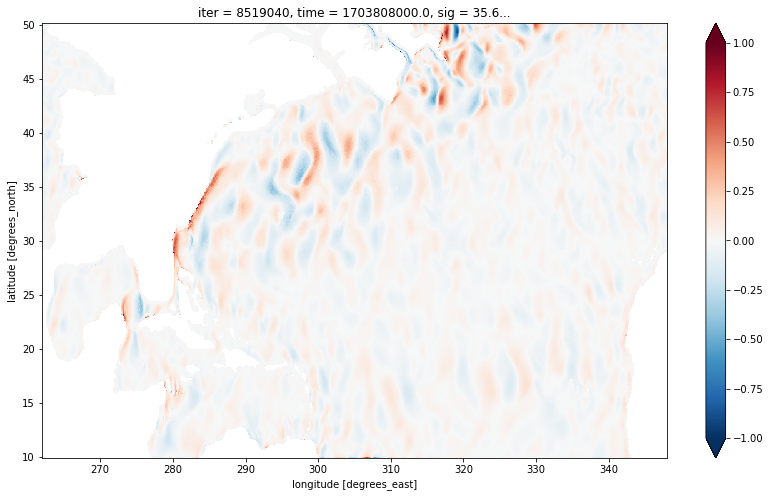

In [125]:
((vdz*grids.interp(dzetaF[t_of_interest],
                   'Y',boundary='fill')**-1)[:,:,25]).where(ds.maskInS!=0.).plot(figsize=(14,8), vmin=-1, vmax=1.,
                                                                                cmap='RdBu_r')

In [21]:
dzetaF = xr.concat([xr.concat([xr.ones_like(Tdz),xr.ones_like(Tdz)], dim='time'),xr.ones_like(Tdz)], dim='time')
dzetaF.coords['time'] = ('time',ds.time.data)

for j in range(3):
    with ProgressBar():
        tmpdzetaF = xr.apply_ufunc(layers_numpy, 
                                       xr.ones_like(rho2[j]).where(ds.maskC!=0.).sel(YC=slice(ystart-12**-1,
                                                                                              yend+2*12**-1)).chunk({'XC':xchunk}),
                                       (rho2[j]-1e3).where(ds.maskC!=0.).sel(YC=slice(ystart-12**-1,
                                                                                    yend+2*12**-1)).chunk({'XC':xchunk}),
                                       kwargs={'thetalayers':siglayers,'mapfact':mapfact,
                                               'mapindex':mapindex,'cellindex':cellindex,
                                               'drf_finer':drf_finer},
                                       dask='parallelized', 
                                       input_core_dims=[['Z'],['Z']], 
                                       output_core_dims=[['sig']],
            #                            output_core_dims=(['sig2lev']),
            #                            exclude_dims=set(['Z']),
                                       output_dtypes=[float,], output_sizes={'sig':siglayers.size}
                                      ).compute()
            
    dzetaF[j] *= tmpdzetaF.data
    
dzetaF

[########################################] | 100% Completed |  0.1s
[########################################] | 100% Completed |  0.1s
[########################################] | 100% Completed |  0.1s
[########################################] | 100% Completed |  0.1s
[########################################] | 100% Completed |  0.2s
[########################################] | 100% Completed |  0.2s
[########################################] | 100% Completed |  0.1s
[########################################] | 100% Completed |  0.1s
[########################################] | 100% Completed |  0.1s
[########################################] | 100% Completed |  0.1s
[########################################] | 100% Completed |  0.1s
[########################################] | 100% Completed |  0.3s
[########################################] | 100% Completed |  0.3s
[########################################] | 100% Completed |  0.1s
[########################################] | 100

<xarray.DataArray (time: 3, YC: 483, XC: 1000, sig: 43)>
array([[[[nan,  0.,  0., ...,  0.,  0.,  0.],
         [nan,  0.,  0., ...,  0.,  0.,  0.],
         [nan,  0.,  0., ...,  0.,  0.,  0.],
         ...,
         [nan,  0.,  0., ...,  0.,  0.,  0.],
         [nan,  0.,  0., ...,  0.,  0.,  0.],
         [nan,  0.,  0., ...,  0.,  0.,  0.]],

        [[nan,  0.,  0., ...,  0.,  0.,  0.],
         [nan,  0.,  0., ...,  0.,  0.,  0.],
         [nan,  0.,  0., ...,  0.,  0.,  0.],
         ...,
         [nan,  0.,  0., ...,  0.,  0.,  0.],
         [nan,  0.,  0., ...,  0.,  0.,  0.],
         [nan,  0.,  0., ...,  0.,  0.,  0.]],

        [[nan,  0.,  0., ...,  0.,  0.,  0.],
         [nan,  0.,  0., ...,  0.,  0.,  0.],
         [nan,  0.,  0., ...,  0.,  0.,  0.],
         ...,
         [nan,  0.,  0., ...,  0.,  0.,  0.],
         [nan,  0.,  0., ...,  0.,  0.,  0.],
         [nan,  0.,  0., ...,  0.,  0.,  0.]],

        ...,

        [[nan,  0.,  0., ...,  0.,  0.,  0.],
       

In [64]:
# dzetaC = dzetaF.interp({'sig':sigp1layers[1:-1]})
# dzetaC = xr.DataArray(xr.concat([xr.concat([.5*dzetaF[:,:,:,:,0],dzetaC], dim='sig'),
#                                 .5*dzetaF[:,:,:,:,-1]], dim='sig').data,
#                      dims=['time','nmemb','YC','XC','sigp1'],
#                      coords={'time':dzetaF.time.data,'nmemb':range(24),
#                             'YC':dzetaF.YC.data,'XC':dzetaF.XC.data,
#                             'sigp1':sigp1layers})
# dzetaC
# try:
#     del dzetaC
# except:
#     print("Already deleted.")


In [23]:
dssig = dzetaF.to_dataset(name='dzetaF')
dssig.coords['YG'] = ('YG',vdz.YG.data)
dssig.coords['XG'] = ('XG',udz.XG.data)
# dssig.coords['rAs'] = (('YG','XC'),vdz.rAs.data)
# dssig.coords['rAw'] = (('YC','XG'),udz.rAw.data)
# dssig.coords['rAs'] = (('YG','XC'),vdz.rAs.data)
# dssig.coords['rAw'] = (('YC','XG'),udz.rAw.data)
dssig.coords['sigp1'] = ('sigp1',sigp1layers)
dt = np.diff(ds.time)[0]
dssig.coords['timep1'] = ('timep1',np.append(np.append(ds.time[0].data-.5*dt,.5*(ds.time[1:].data+ds.time[:-1].data)),
                                             ds.time[-1].data+.5*dt))
dssig

<xarray.Dataset>
Dimensions:  (XC: 1000, XG: 1000, YC: 483, YG: 483, sig: 43, sigp1: 44, time: 3, timep1: 4)
Coordinates:
    Depth    (YC, XC) >f4 0.0 0.0 0.0 0.0 ... 2158.6245 2158.6245 2124.6829
    maskInC  (YC, XC) bool False False False False False ... True True True True
    iter     int64 8519040
    rA       (YC, XC) >f4 87318950.0 87318950.0 ... 56879988.0 56879988.0
  * sig      (sig) float64 27.5 27.54 27.6 27.67 ... 37.16 37.18 37.19 37.2
  * XC       (XC) >f4 262.00003 262.0861 262.17215 ... 347.88644 347.9725
  * YC       (YC) >f4 9.916701 10.000034 10.083367 ... 50.000034 50.08337
  * time     (time) float64 1.703e+09 1.704e+09 1.704e+09
  * YG       (YG) >f4 9.958367 10.041701 10.125034 ... 50.041702 50.125034
  * XG       (XG) >f4 261.957 262.04306 262.12912 ... 347.8434 347.92947
  * sigp1    (sigp1) float64 27.48 27.52 27.57 27.63 ... 37.17 37.18 37.19 37.21
  * timep1   (timep1) float64 1.703e+09 1.704e+09 1.704e+09 1.704e+09
Data variables:
    dzetaF   (time, YC,

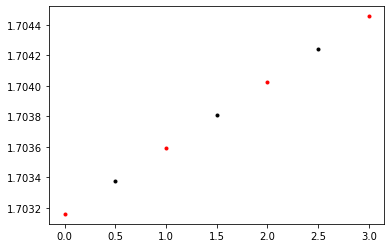

In [26]:
fig, ax = plt.subplots()
ax.plot(np.arange(.5,3), dssig.time*1e-9, 'k.')
ax.plot(np.arange(0,4), dssig.timep1*1e-9, 'r.')
# ax.set_ylim([1.703,1.704])

In [87]:
grids = xgrid(dssig, periodic=['X'], 
              coords={'T':{'center':'time','outer':'timep1'},
                      'Z':{'center':'sig','outer':'sigp1'},
                      'Y':{'center':'YC','left':'YG'},
                      'X':{'center':'XC','left':'XG'}})
grids

<xgcm.Grid>
T Axis (not periodic):
  * center   time --> outer
  * outer    timep1 --> center
Z Axis (not periodic):
  * center   sig --> outer
  * outer    sigp1 --> center
Y Axis (not periodic):
  * center   YC --> left
  * left     YG --> center
X Axis (periodic):
  * center   XC --> left
  * left     XG --> center

In [98]:
vb = vdz * grids.interp(dzetaF[1],'Y',boundary='fill')**-1
ub = udz * grids.interp(dzetaF[1],'X')**-1
print(vb.dims, ub.dims)

('YG', 'XC', 'sig') ('YC', 'XG', 'sig')


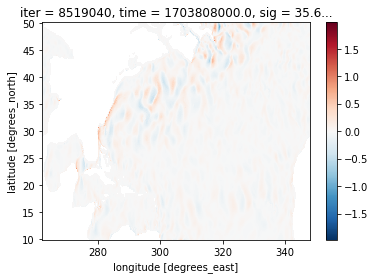

In [104]:
vb[:,:,25].plot()

In [28]:
sigma = (dzetaF[t_of_interest] * grids.diff(dssig.sigp1,'Z',boundary='fill')**-1)
zeta = grids.interp(grids.cumsum(dzetaF[t_of_interest],'Z',boundary='fill'),'Z',boundary='fill')
sigma

<xarray.DataArray (YC: 483, XC: 1000, sig: 43)>
array([[[nan,  0.,  0., ...,  0.,  0.,  0.],
        [nan,  0.,  0., ...,  0.,  0.,  0.],
        [nan,  0.,  0., ...,  0.,  0.,  0.],
        ...,
        [nan,  0.,  0., ...,  0.,  0.,  0.],
        [nan,  0.,  0., ...,  0.,  0.,  0.],
        [nan,  0.,  0., ...,  0.,  0.,  0.]],

       [[nan,  0.,  0., ...,  0.,  0.,  0.],
        [nan,  0.,  0., ...,  0.,  0.,  0.],
        [nan,  0.,  0., ...,  0.,  0.,  0.],
        ...,
        [nan,  0.,  0., ...,  0.,  0.,  0.],
        [nan,  0.,  0., ...,  0.,  0.,  0.],
        [nan,  0.,  0., ...,  0.,  0.,  0.]],

       [[nan,  0.,  0., ...,  0.,  0.,  0.],
        [nan,  0.,  0., ...,  0.,  0.,  0.],
        [nan,  0.,  0., ...,  0.,  0.,  0.],
        ...,
        [nan,  0.,  0., ...,  0.,  0.,  0.],
        [nan,  0.,  0., ...,  0.,  0.,  0.],
        [nan,  0.,  0., ...,  0.,  0.,  0.]],

       ...,

       [[nan,  0.,  0., ...,  0.,  0.,  0.],
        [nan,  0.,  0., ...,  0.,  0., 

In [30]:
zeta.dims

('YC', 'XC', 'sig')

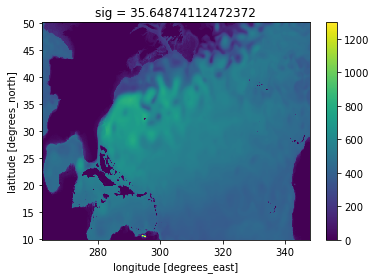

In [31]:
zeta[:,:,25].plot()

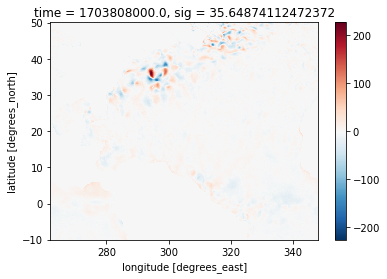

In [67]:
zeta[:,0,:,:,25].diff('time').plot()

In [32]:
# nb = (np.array([dzetaC/gridz.interp(ds.dxG,'Y',boundary='fill'),dzetaC/gridz.interp(ds.dyG,'X'),-1]) 
#       * (1+(dzetaC/gridz.interp(ds.dxG,'Y',boundary='fill'))**2+(dzetaC/gridz.interp(ds.dyG,'X'))**2)**-1)
# nb
angle = np.sqrt(1 + (dzetaF[t_of_interest]/gridz.interp(ds.dxG,'Y',boundary='fill'))**2 
                + (dzetaF[t_of_interest]/gridz.interp(ds.dyG,'X'))**2)**-1
angley = np.sqrt(1 + (grids.interp(dzetaF[t_of_interest],'Y',boundary='fill')/ds.dxG)**2 
                + (grids.interp(dzetaF[t_of_interest],'Y',boundary='fill')
                   /gridz.interp(gridz.interp(ds.dyG,'X'),'Y',boundary='fill'))**2)**-1
anglex = np.sqrt(1 + (grids.interp(dzetaF[t_of_interest],'X')
                      /gridz.interp(gridz.interp(ds.dxG,'Y',boundary='fill'),'X'))**2 
                + (grids.interp(dzetaF[t_of_interest],'X')/ds.dyG)**2)**-1
anglez = np.sqrt(1 + (grids.interp(dzetaF[t_of_interest],'Z',boundary='fill')
                      /gridz.interp(ds.dxG,'Y',boundary='fill'))**2 
                 + (grids.interp(dzetaF[t_of_interest],'Z',boundary='fill')
                    /gridz.interp(ds.dyG,'X'))**2)**-1
print(angle,angley,anglex,anglez)

<xarray.DataArray (YC: 483, XC: 1000, sig: 43)>
dask.array<pow, shape=(483, 1000, 43), dtype=float32, chunksize=(483, 499, 43), chunktype=numpy.ndarray>
Coordinates:
  * YC       (YC) float64 9.917 10.0 10.08 10.17 ... 49.83 49.92 50.0 50.08
    Depth    (YC, XC) >f4 0.0 0.0 0.0 0.0 ... 2158.6245 2158.6245 2124.6829
    maskInC  (YC, XC) bool False False False False False ... True True True True
    iter     int64 8519040
    rA       (YC, XC) >f4 87318950.0 87318950.0 ... 56879988.0 56879988.0
  * sig      (sig) float64 27.5 27.54 27.6 27.67 ... 37.16 37.18 37.19 37.2
  * XC       (XC) >f4 262.00003 262.0861 262.17215 ... 347.88644 347.9725
    time     float64 1.704e+09 <xarray.DataArray (YG: 483, XC: 1000, sig: 43)>
dask.array<pow, shape=(483, 1000, 43), dtype=float32, chunksize=(483, 499, 43), chunktype=numpy.ndarray>
Coordinates:
  * YG       (YG) float64 9.958 10.04 10.13 10.21 ... 49.88 49.96 50.04 50.13
  * XC       (XC) >f4 262.00003 262.0861 262.17215 ... 347.88644 347.9725
 

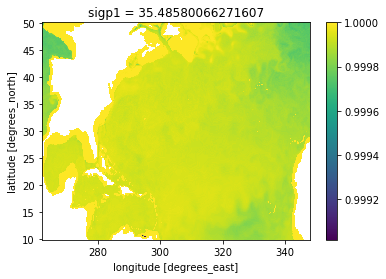

In [118]:
(anglez[:,:,25]).where(ds.maskInC!=0.).plot()

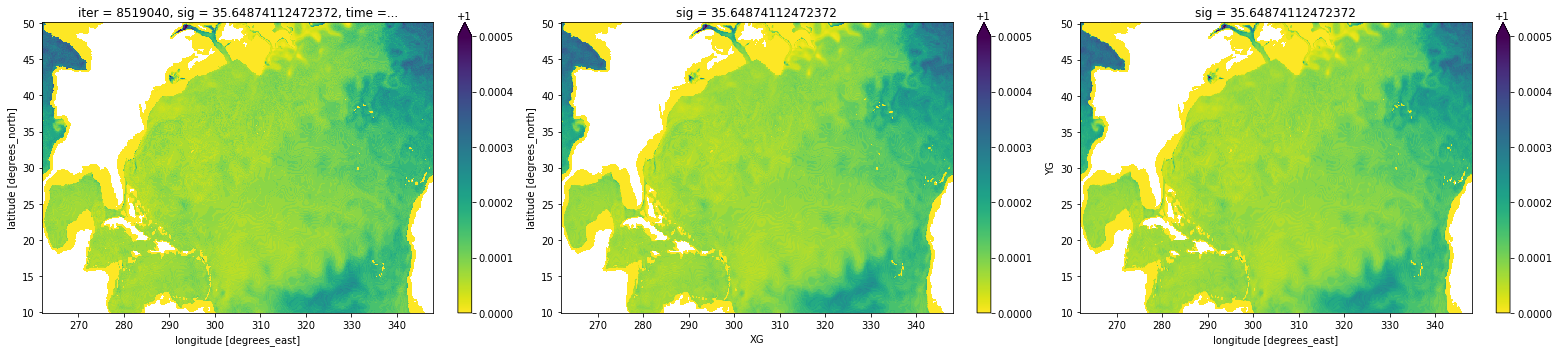

In [71]:
rAb = angle**-1 * ds.rA
rAbw = anglex**-1 * ds.rAw
rAbs = angley**-1 * ds.rAs
rAbz = anglez**-1 * ds.rA

fig, (ax1,ax2,ax3) = plt.subplots(figsize=(22,5), nrows=1, ncols=3)
fig.set_tight_layout(True)
(rAb[:,:,25]/ds.rA).where(ds.maskInC!=0.).plot(ax=ax1, cmap='viridis_r', vmin=1, vmax=1.0005)
(rAbw[:,:,25]/ds.rAw).where(ds.maskInW!=0.).plot(ax=ax2, cmap='viridis_r', vmin=1, vmax=1.0005)
(rAbs[:,:,25]/ds.rAs).where(ds.maskInS!=0.).plot(ax=ax3, cmap='viridis_r', vmin=1, vmax=1.0005)

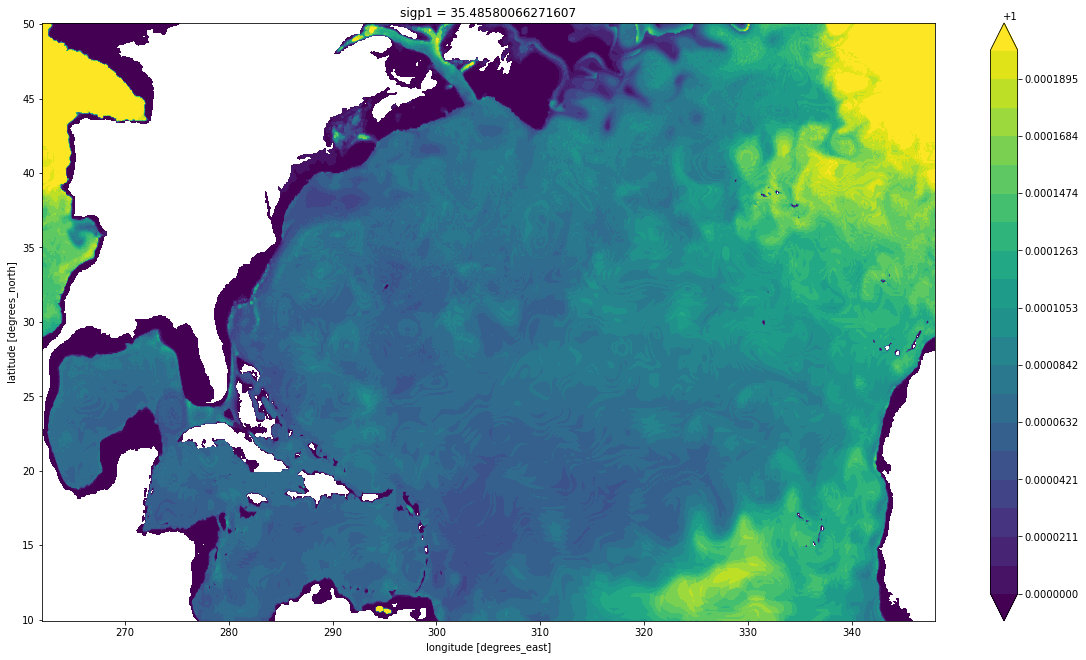

In [155]:
(rAbz[:,:,25]/ds.rA).where(ds.maskInC!=0.).plot.contourf(figsize=(20,11), levels=np.linspace(1,1.0002,20), extend='both')

In [35]:
# zeta_t = grids.interp(grids.diff(zeta,'T',boundary='extend') * dt**-1,
#                       'T',boundary='fill')[0]
zeta_t = grids.interp(grids.diff(grids.interp(grids.cumsum(dzetaF,'Z',boundary='fill'),'Z',boundary='fill'),
                                 'T',boundary='fill'),
                      'T',boundary='fill')[1]*dt**-1
zeta_t.dims

('YC', 'XC', 'sig')

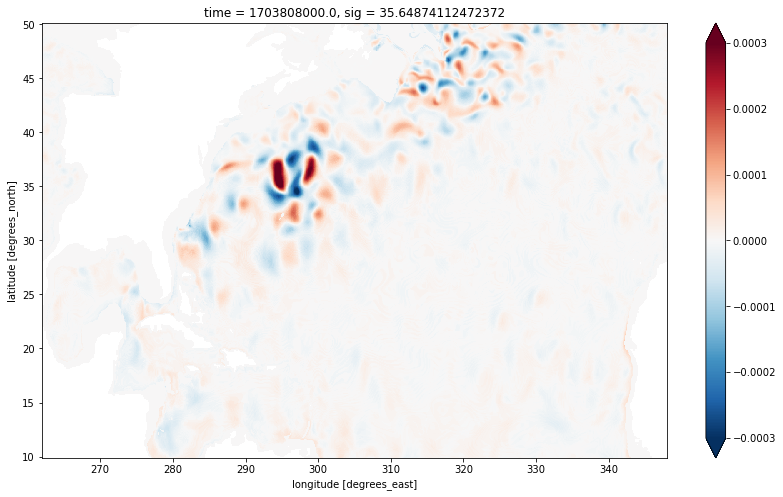

In [40]:
(zeta_t[:,:,25]).where(ds.maskInC!=0.).plot(figsize=(14,8), vmax=3e-4)

In [116]:
dbdT = grids.diff(Tdz*dzetaF[t_of_interest]**-1*rAb,
                  'Z',boundary='fill'
                 )**-1 * (grids.diff(dssig.sig,'Z',boundary='fill') 
                          * rAbz
                         )
dbds = grids.diff(sdz*dzetaF[t_of_interest]**-1*rAb,
                  'Z',boundary='fill'
                 )**-1 * (grids.diff(dssig.sig,'Z',boundary='fill') 
                          * rAbz
                         )

varpi = (dbdT*grids.interp(GTdz*dzetaF[t_of_interest]**-1,'Z',boundary='fill') 
         + dbds*grids.interp(Gsdz*dzetaF[t_of_interest]**-1,'Z',boundary='fill')
        )
varpi

<xarray.DataArray (YC: 483, XC: 1000, sigp1: 44)>
dask.array<add, shape=(483, 1000, 44), dtype=float64, chunksize=(483, 499, 42), chunktype=numpy.ndarray>
Coordinates:
  * YC       (YC) >f4 9.916701 10.000034 10.083367 ... 50.000034 50.08337
  * XC       (XC) >f4 262.00003 262.0861 262.17215 ... 347.88644 347.9725
  * sigp1    (sigp1) float64 27.48 27.52 27.57 27.63 ... 37.17 37.18 37.19 37.21
    rA       (YC, XC) >f4 87318950.0 87318950.0 ... 56879988.0 56879988.0
    Depth    (YC, XC) >f4 0.0 0.0 0.0 0.0 ... 2158.6245 2158.6245 2124.6829
    maskInC  (YC, XC) bool False False False False False ... True True True True

/tank/users/tuchida/miniconda3/envs/ensemble/lib/python3.7/site-packages/dask/core.py:119: RuntimeWarning: divide by zero encountered in reciprocal
  return func(*args2)


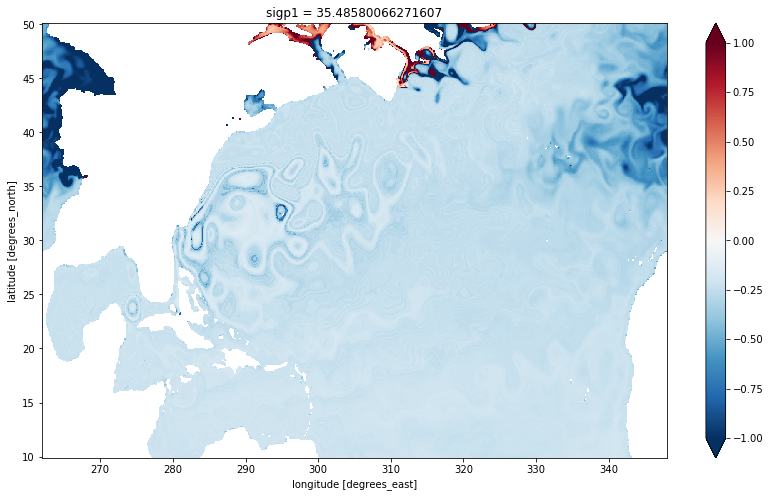

In [54]:
(dbdT[:,:,25]).where(ds.maskInC!=0.).plot(figsize=(14,8), vmax=1)

/tank/users/tuchida/miniconda3/envs/ensemble/lib/python3.7/site-packages/dask/core.py:119: RuntimeWarning: divide by zero encountered in reciprocal
  return func(*args2)
/tank/users/tuchida/miniconda3/envs/ensemble/lib/python3.7/site-packages/dask/core.py:119: RuntimeWarning: invalid value encountered in add
  return func(*args2)


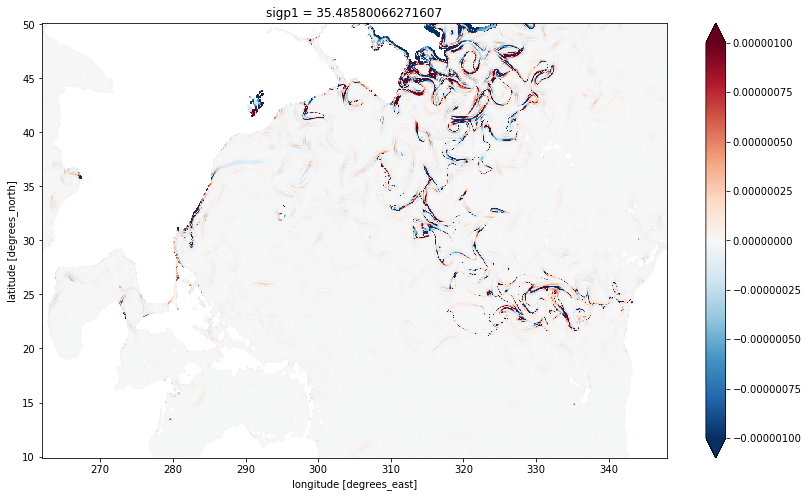

In [45]:
(varpi[:,:,25]).where(ds.maskInC!=0.).plot(figsize=(14,8), vmax=1e-6)

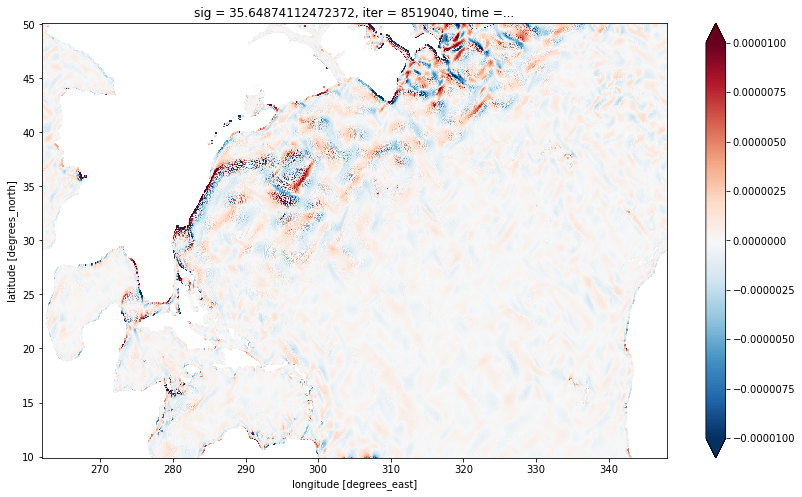

In [100]:
(grids.diff(ub*grids.diff(dssig.sigp1,'Z',boundary='fill')
            * ds.dyG * np.sqrt(1 + (grids.interp(dzetaF[t_of_interest],'X')/ds.dyG)**2)**-1, 'X'
           ) 
 * (rAb*grids.diff(dssig.sigp1,'Z',boundary='fill'))**-1
)[:,:,25].plot(figsize=(14,8), vmax=1e-5)

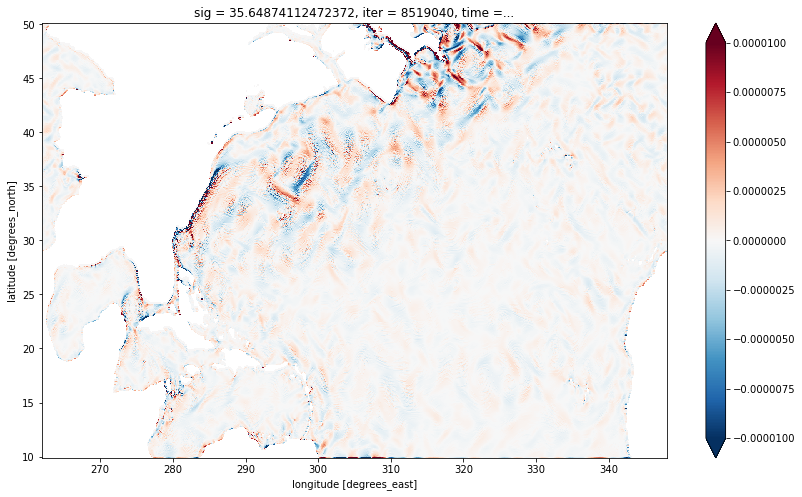

In [105]:
(grids.diff(vb*grids.diff(dssig.sigp1,'Z',boundary='fill')*ds.dxG 
            * np.sqrt(1 + (grids.interp(dzetaF[t_of_interest],'Y',boundary='fill')/ds.dxG)**2)**-1,'Y',boundary='fill'
           ) 
 * (rAb*grids.diff(dssig.sigp1,'Z',boundary='fill'))**-1)[:,:,25].plot(figsize=(14,8), vmax=1e-5)

/tank/users/tuchida/miniconda3/envs/ensemble/lib/python3.7/site-packages/dask/core.py:119: RuntimeWarning: divide by zero encountered in reciprocal
  return func(*args2)
/tank/users/tuchida/miniconda3/envs/ensemble/lib/python3.7/site-packages/dask/core.py:119: RuntimeWarning: invalid value encountered in add
  return func(*args2)


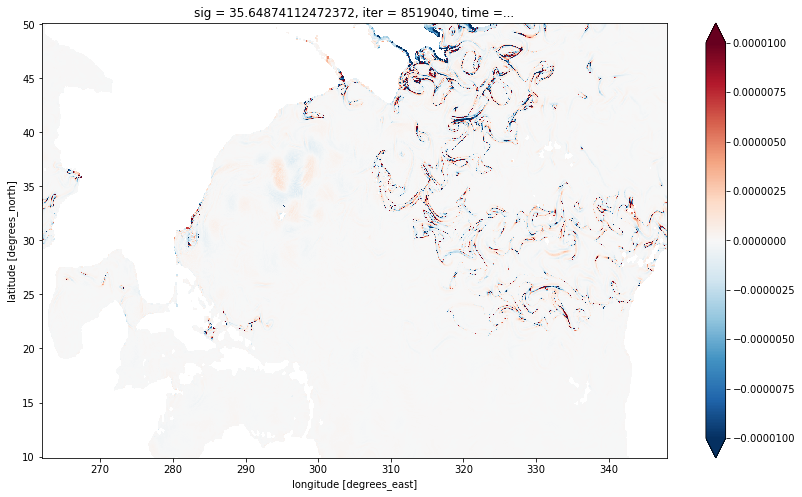

In [112]:
(-grids.diff(grids.interp(sigma,'Z',boundary='fill')**-1
             * (grids.interp(zeta_t,'Z',boundary='fill') + varpi*grids.interp(sigma,'Z',boundary='fill'))*rAbz,
             'Z',boundary='fill') 
 * (rAb*grids.diff(dssig.sigp1,'Z',boundary='fill'))**-1)[:,:,25].plot(figsize=(14,8), vmax=1e-5)

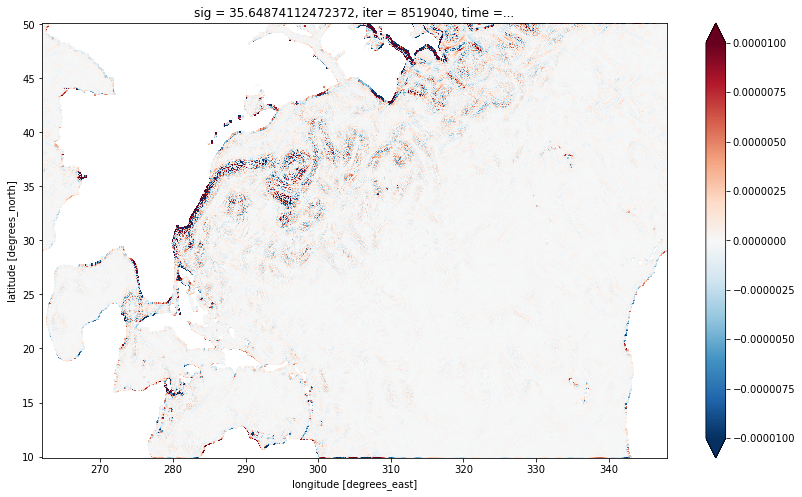

In [113]:
((grids.diff(ub*grids.diff(dssig.sigp1,'Z',boundary='fill')*ds.dyG 
                   * np.sqrt(1 + (grids.interp(dzetaF[t_of_interest],'X')/ds.dyG)**2)**-1,'X'
                  ) 
        + grids.diff(vb*grids.diff(dssig.sigp1,'Z',boundary='fill')*ds.dxG 
                     * np.sqrt(1 + (grids.interp(dzetaF[t_of_interest],'Y',boundary='fill')/ds.dxG)**2)**-1,'Y',boundary='fill'
                    )
       ) * (rAb*grids.diff(dssig.sigp1,'Z',boundary='fill'))**-1)[:,:,25].plot(figsize=(14,8), vmax=1e-5)

In [109]:
divb = (grids.diff(ub*grids.diff(dssig.sigp1,'Z',boundary='fill')*ds.dyG 
                   * np.sqrt(1 + (grids.interp(dzetaF[t_of_interest],'X')/ds.dyG)**2)**-1,'X'
                  ) 
        + grids.diff(vb*grids.diff(dssig.sigp1,'Z',boundary='fill')*ds.dxG 
                     * np.sqrt(1 + (grids.interp(dzetaF[t_of_interest],'Y',boundary='fill')/ds.dxG)**2)**-1,'Y',boundary='fill'
                    )
        + (-grids.diff(grids.interp(sigma,'Z',boundary='fill')**-1
                       * (grids.interp(zeta_t,'Z',boundary='fill') + varpi*grids.interp(sigma,'Z',boundary='fill'))*rAbz,
                       'Z',boundary='fill'))
       ) * (rAb*grids.diff(dssig.sigp1,'Z',boundary='fill'))**-1

divb

<xarray.DataArray (YC: 483, XC: 1000, sig: 43)>
dask.array<mul, shape=(483, 1000, 43), dtype=float64, chunksize=(482, 499, 41), chunktype=numpy.ndarray>
Coordinates:
  * YC       (YC) float64 9.917 10.0 10.08 10.17 ... 49.83 49.92 50.0 50.08
  * XC       (XC) >f4 262.00003 262.0861 262.17215 ... 347.88644 347.9725
  * sig      (sig) float64 27.5 27.54 27.6 27.67 ... 37.16 37.18 37.19 37.2
    Depth    (YC, XC) >f4 0.0 0.0 0.0 0.0 ... 2158.6245 2158.6245 2124.6829
    maskInC  (YC, XC) bool False False False False False ... True True True True
    iter     int64 8519040
    rA       (YC, XC) >f4 87318950.0 87318950.0 ... 56879988.0 56879988.0
    time     float64 1.704e+09

/tank/users/tuchida/miniconda3/envs/ensemble/lib/python3.7/site-packages/dask/core.py:119: RuntimeWarning: divide by zero encountered in reciprocal
  return func(*args2)
/tank/users/tuchida/miniconda3/envs/ensemble/lib/python3.7/site-packages/dask/core.py:119: RuntimeWarning: invalid value encountered in add
  return func(*args2)


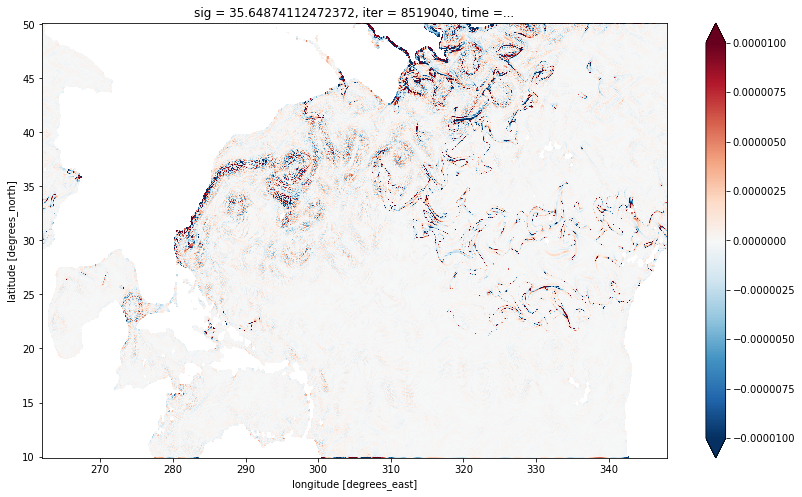

In [110]:
divb[:,:,25].plot(figsize=(14,8), vmax=1e-5)